# Generative Models for text (LSTM to mimic Bertrand Russell's writing) and Image Colorisation

### Importing the required packages

In [1]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import glob #For reading the files

from sklearn.model_selection import train_test_split #For splitting the data into train and test sets
from sklearn import preprocessing #For encoding class labels
from sklearn.model_selection import GridSearchCV #To perform cross validation in order to obtain the best hyperparameters
from sklearn.svm import LinearSVC #To implement linear Support Vector Classifiers
from sklearn.model_selection import cross_validate #To perform cross validation in order to obtain the best hyperparameters
from sklearn.model_selection import cross_val_score #To perform cross validation in order to obtain the best hyperparameters
from sklearn.preprocessing import StandardScaler # To standardize data
from sklearn.metrics import hamming_loss #To compute hamming loss
from sklearn.metrics import silhouette_score #To compute silhouette score
from sklearn.metrics import accuracy_score #To calculate exact match score
from sklearn.metrics import confusion_matrix # To compute confusion matrix
from sklearn.metrics import classification_report # To compute f1-score
from sklearn.utils import shuffle #To shuffle data
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_auc_score # For ROC curve and AUC
from sklearn.cluster import KMeans #To preform k-means clustering
from scipy.spatial import distance
import sklearn as skl
from sklearn.model_selection import StratifiedKFold #For stratifying
from skimage.color import rgb2gray

#Importing the required library
from imblearn.over_sampling import SMOTE
import random

In [2]:
%%bash
cd Documents/USC_Masters/ML/Homework7/data/
ls

MysticismAndLogicAndOtherEssays.txt
OurKnowledgeOfTheExternalWorld.txt
TheAnalysisOfMind.txt
TheProblemsOfPhilosophy.txt


### Reading each of the books

In [194]:
with open('Documents/USC_Masters/ML/Homework7/data/MysticismAndLogicAndOtherEssays.txt', 'r') as content_file:
    content_1 = content_file.read()

with open('Documents/USC_Masters/ML/Homework7/data/OurKnowledgeOfTheExternalWorld.txt', 'r') as content_file2:
    content_2 = content_file2.read()

with open('Documents/USC_Masters/ML/Homework7/data/TheAnalysisOfMind.txt', 'r') as content_file3:
    content_3 = content_file3.read()
    
with open('Documents/USC_Masters/ML/Homework7/data/TheProblemsOfPhilosophy.txt', 'r') as content_file4:
    content_4 = content_file4.read()

In [657]:
print(len(content_1))
print(len(content_2))
print(len(content_3))
print(len(content_4))
print(len(content_1)+len(content_2)+len(content_3)+len(content_4))

424747
420381
520908
245837
1611873


### Merging the contents of all the books into a single corpus

In [658]:
corpus_final = content_1+content_2+content_3+content_4

In [659]:
count = 0
chars = []
for i in corpus_final:
    #count = count+1
    if i.isalpha:
        i = i.lower()
    if i.isalnum() or i == ' ':
        if ord(i)<=255:
            count=count+1
print(count)

1537704


### Obtaining the unique characters in the corpus

In [660]:
#count = 0
chars = []
for i in corpus_final:
    #count = count+1
    if i.isalpha:
        i = i.lower()
    if i.isalnum() or i == ' ':
        if i not in chars:
            chars.append(i)
print(chars)
print(len(chars))

['p', 'r', 'o', 'd', 'u', 'c', 'e', ' ', 'b', 'y', 'j', 'a', 'n', 'i', 'h', 'w', 's', 'm', 't', 'l', 'f', 'g', 'v', 'q', 'k', 'x', 'z', '1', '9', '0', '7', '8', '2', '5', '3', '4', '6', 'é', 'œ', 'æ', 'ü', 'ï', 'ŭ', 'α', 'β', 'ô', 'κ', 'θ', 'τ', 'γ', 'ã', 'â', 'ὸ', 'π', 'ό', 'σ', 'ο', 'ν', 'η', 'λ', 'ί', 'ὴ', 'φ', 'ι', 'ρ', 'ή', 'è', 'ë', 'î', 'ö']
70


### Obtaining the ASCII value for each of the unique characters and storing the characters with a ASCII value below 255 only

In [661]:
ascii_chars = []
for i in chars:
    #CHECK IF ASCII CHARACTERS
    if ord(i)<=255:
        print(i,":",ord(i))
        ascii_chars.append(ord(i))
    else:
        chars.remove(i)

p : 112
r : 114
o : 111
d : 100
u : 117
c : 99
e : 101
  : 32
b : 98
y : 121
j : 106
a : 97
n : 110
i : 105
h : 104
w : 119
s : 115
m : 109
t : 116
l : 108
f : 102
g : 103
v : 118
q : 113
k : 107
x : 120
z : 122
1 : 49
9 : 57
0 : 48
7 : 55
8 : 56
2 : 50
5 : 53
3 : 51
4 : 52
6 : 54
é : 233
ü : 252
ï : 239
ã : 227
â : 226
è : 232
ë : 235
î : 238
ö : 246


In [722]:
i = '9'
i = i.lower()
print(i)

9


### Removing the characters which have an ASCII value greater than 256 from the original corpus

In [663]:
new_corpus_list = []
new_corpus = ''
count = 0
for i in corpus_final:
    if i in chars:
        #print(i,":",ord(i))
        count = count+1
        #new_corpus_list.append((ord(i)-min(ascii_chars))/(max(ascii_chars)-min(ascii_chars)))
        new_corpus = new_corpus+i
    elif i.isupper():
        count = count+1
        i = i.lower()
        #new_corpus_list.append((ord(i)-min(ascii_chars))/(max(ascii_chars)-min(ascii_chars)))
        new_corpus = new_corpus+i

### Forming two lists -
1. __input_text__ - A list of lists, with each sub list consisting 99 characters each.<br>
2. __output_character__ - A list with the same length as the above list, each containing the 100th character of the window(The output for each associated character).

In [665]:
window_size = 100
len_new_corpus = len(new_corpus)
input_text = []
output_character = []
count = 0
for i in range(0,len_new_corpus,1):
    if (i+window_size-1) == len_new_corpus:
        break
    input_text.append(new_corpus[i:i+window_size-1])
    output_character.append(new_corpus[i+window_size-1])
print(len(output_character))
print(len(input_text))

1537635
1537635


### Performing one hot encoding on the list of unique characters

In [666]:
from sklearn.preprocessing import OneHotEncoder
le = preprocessing.LabelEncoder()
one_hot = pd.get_dummies(chars)
one_hot.style

,,0,1,2,3,4,5,6,7,8,9,a,b,c,d,e,f,g,h,i,j,k,l,m,n,o,p,q,r,s,t,u,v,w,x,y,z,â,ã,æ,è,é,ë,î,ï,ô,ö,ü,α,γ,θ,ι,λ,ν,π,σ,ὴ,ή
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Assigning the one hot encoded label to each character in the output list

In [667]:
output_character_encoded = []
for i in output_character:
    #print(one_hot.loc[:]['1'])
    output_character_encoded.append(list(one_hot.loc[:][i]))

In [668]:
output_character_encoded = np.array(output_character_encoded)
print(output_character_encoded.shape)

(1537635, 58)


### Normalizing each of the characters based on the minimum and maximum ascii values of characters in the list of unique characters

In [669]:
new_input_text = []
for i in input_text:
    temp = []
    #print(i)
    for j in i:
        temp.append((ord(j)-min(ascii_chars))/(max(ascii_chars)-min(ascii_chars)))
    new_input_text.append(temp)
    #print(new_input_text)

### Checking the shape of dependent variables and independent variables in the train dataset

In [753]:
X_Train = np.array(new_input_text)
print("X Train Shape:",X_Train.shape)
Y_Train = np.array(output_character_encoded)
print("Y Train Shape:",Y_Train.shape)

X Train Shape: (1537635, 99)
Y Train Shape: (1537635, 58)


### Reshaping the train data to fit into the LSTM model

In [754]:
X_Train = X_Train.reshape(1537635, 99,1)
print(X_Train[0].shape)

(99, 1)


### Importing the required libraries for the LSTM model

In [755]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Masking, Embedding
from keras.callbacks import ModelCheckpoint

In [756]:
#Initializing a Sequential Model
lstm_model = Sequential()

#Obtaining the shape of each observation
input_shape = X_Train[0].shape

#Adding an LSTM Layer
lstm_model.add(LSTM(99,input_shape=input_shape,activation='relu'))

#Adding another hidden layer
lstm_model.add(Dense(256,activation='relu'))

#Adding another softmax layer which returns probabilities
lstm_model.add(Dense(58,activation='softmax'))

#Compiling the model
lstm_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

#Adding a checkpoint to keep track of the best state of the model
filepath="lstm_BertrandRussell-{epoch:02d}-{loss:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [678]:
#Fitting the model
lstm_fitted = lstm_model.fit(X_Train,Y_Train,epochs=5,batch_size=128,callbacks=callbacks_list)

Epoch 1/5
1537635/1537635 [==============================] - 1018s 662us/step - loss: 2.7198 - acc: 0.2100

Epoch 00001: loss improved from inf to 2.71976, saving model to lstm_BertrandRussell-01-2.7198.hdf5
Epoch 2/5
1537635/1537635 [==============================] - 1014s 659us/step - loss: 2.5404 - acc: 0.2534

Epoch 00002: loss improved from 2.71976 to 2.54045, saving model to lstm_BertrandRussell-02-2.5404.hdf5
Epoch 3/5
1537635/1537635 [==============================] - 1013s 659us/step - loss: 2.3893 - acc: 0.3000

Epoch 00003: loss improved from 2.54045 to 2.38934, saving model to lstm_BertrandRussell-03-2.3893.hdf5
Epoch 4/5
1537635/1537635 [==============================] - 1015s 660us/step - loss: 2.2683 - acc: 0.3390

Epoch 00004: loss improved from 2.38934 to 2.26829, saving model to lstm_BertrandRussell-04-2.2683.hdf5
Epoch 5/5
1537635/1537635 [==============================] - 1042s 677us/step - loss: 2.1770 - acc: 0.3715

Epoch 00005: loss improved from 2.26829 to 2.177

In [717]:
filename = "lstm_BertrandRussell-05-2.1770.hdf5"
lstm_model.load_weights(filename)
lstm_model.compile(loss='categorical_crossentropy', optimizer='adam')

### Input text to test our model

In [718]:
test_text = "There are those who take mental phenomena naively, just as they would physical phenomena. This school of psychologists tends not to emphasize the object."
test_text_list = []
new_text = ''
for i in test_text:
    #if i in chars:
    if i != '.':
        test_text_list.append(i)
        new_text = new_text+i


### Normalizing the values based on the minimum and maximum ascii values of characters in the list of unique characters before feeding it into the model

In [720]:
ouput_lstm = ''
for i in test_text_list:
        temp.append((ord(i)-min(ascii_chars))/(max(ascii_chars)-min(ascii_chars)))

#Forming a new 1000 characters output with 
for i in range(1000):
    start_text = temp[-99:]
    x = np.reshape(start_text, (1, 99,1))
    index = 0
    prediction = lstm_model.predict(x, verbose=0)
    index = np.argmax(prediction)
    append_char = chars[index]
    new_text = new_text+append_char
    temp.append((ord(append_char)-min(ascii_chars))/(max(ascii_chars)-min(ascii_chars)))
print(new_text)

There are those who take mental phenomena naively, just as they would physical phenomena This school of psychologists tends not to emphasize the object of the semee of the semee of the semee of the semee of the semee of the semee of the semee of the semee of the semee of the semee of the semee of the semee of the semee of the semee of the semee of the semee of the semee of the semee of the semee of the semee of the semee of the semee of the semee of the semee of the semee of the semee of the semee  of the semee of the semee of the semee of the semee of the semee of the semee of the semee of the semee of the semee of the semee of the semee of the semee of the semee of the semee of the semee of the semee of the semee of the semee of the semee of the semee of the semee of the semee of the semee of the semee of the semee of the semee of the semee of the semee of the semee of the semee of the semee of the semee of the semee of the semee of the semee of the semee of the semee of the semee of

## Convolutional Neural Network

### Importing the required libraries

In [152]:
import keras
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense,Conv2D,Flatten,MaxPool2D
from keras.utils import to_categorical

### Reading the CIFAR-10 dataset

In [12]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


### Getting indices from the train and test dataset where the images are not birds

In [13]:
#Getting indices from the train and test dataset where the images are not birds, i.e label is not 2
indices_train = np.where(y_train != 2)[0]
indices_test = np.where(y_test != 2)[0]

### Deleting all images except the images of birds

In [14]:
#Deleting all observations except that of birds
x_train_birds = np.delete(x_train, indices_train, axis=0)
x_test_birds = np.delete(x_test, indices_test, axis=0)

y_train_birds = np.delete(y_train, indices_train, axis=0)
y_test_birds = np.delete(y_test, indices_test, axis=0)

### Checking the size of train and test dataset

In [15]:
print(x_train_birds.shape)
print(x_test_birds.shape)

print(y_train_birds.shape)
print(y_test_birds.shape)

(5000, 32, 32, 3)
(1000, 32, 32, 3)
(5000, 1)
(1000, 1)


### Forming a dataset with all images to run k-means

In [63]:
x_birds_all = np.concatenate((x_train_birds, x_test_birds), axis=0)
print(x_birds_all.shape)

(6000, 32, 32, 3)


### Re-shaping the numpy array to an array of individual pixels

In [100]:
x_birds_reshape = x_birds_all.reshape(6144000,-1)
print(x_birds_reshape.shape)

(6144000, 3)


### Running K-Means Clustering for k=4

In [121]:
kmeans = KMeans(n_clusters=4, random_state=4).fit(x_birds_reshape)
    
#Obtaining the clusters to which each observation belongs
labels = kmeans.labels_
    
#Obtaining the clusters centers of each cluster
clusters_centers = kmeans.cluster_centers_


#print(labels)
print(clusters_centers)

[[108.32076146 108.00174774  82.21561863]
 [155.91334478 155.19370353 135.04372854]
 [206.39011312 211.64065492 211.27289846]
 [ 48.53215478  49.51816877  38.19140651]]


### Forming a new list of pixels which associates each pixel to the center of the cluster it belongs to

In [730]:
New_pixels = []
for i in labels:
    New_pixels.append(clusters_centers[i])

### Converting the above list to a numpy array

In [731]:
New_pixels = np.asarray(New_pixels)
print(New_pixels.shape)

#Wrapping the array into np.uint8() because matplot lib does not accept floats
New_pixels = np.uint8(New_pixels)
print(New_pixels.shape)

(6144000, 3)
(6144000, 3)


### Reshaping the array to it's original shape

In [732]:
k_means_output = New_pixels.reshape(6000, 32, 32, 3)

### Displaying the new image with pixels replaced by cluster centers and the old image for the first ten images of birds

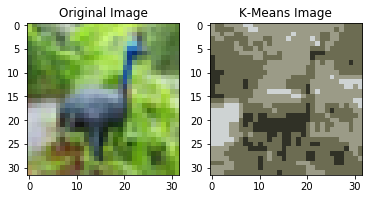

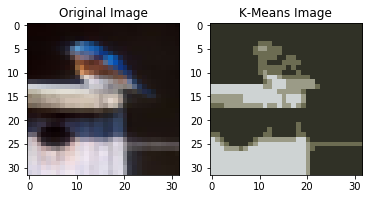

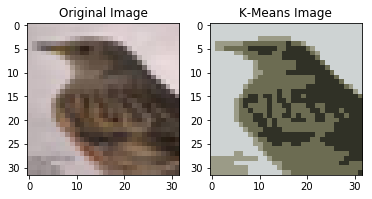

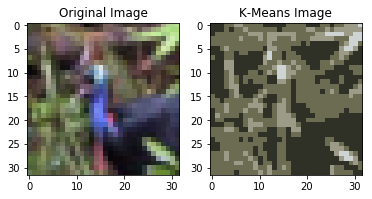

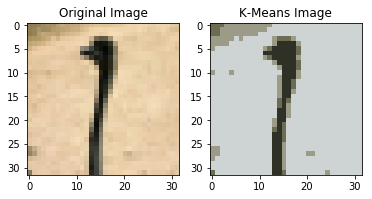

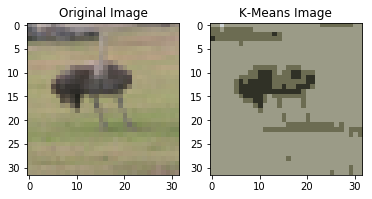

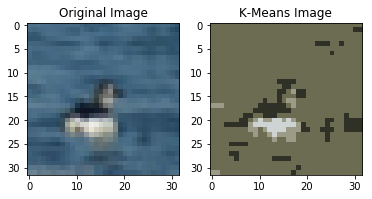

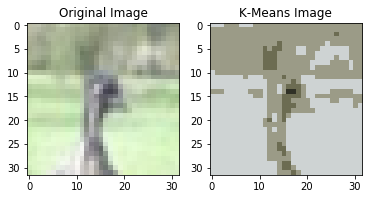

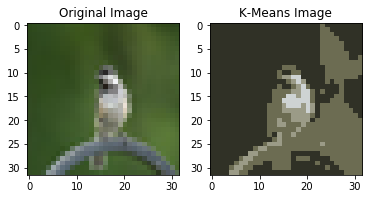

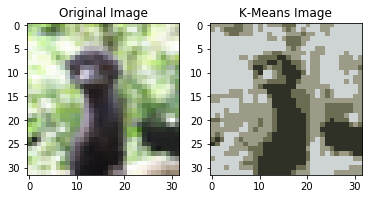

In [733]:
for i in range(10):
    #print("Image:",i+1)
    plt.figure(figsize=(6,6))
    plt.subplot(1, 2, 1)
    plt.imshow(x_birds_all[i])
    plt.title("Original Image")
    plt.subplot(1, 2, 2)
    plt.imshow(k_means_output[i])
    plt.title("K-Means Image")

### Displaying the new image with pixels replaced by colours suggested by professor in the homework and the old image for the first ten images of birds

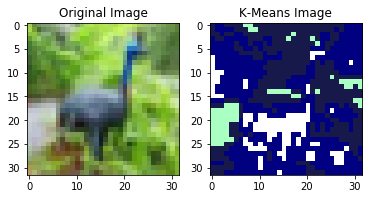

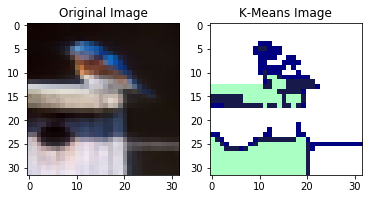

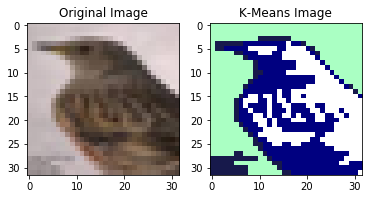

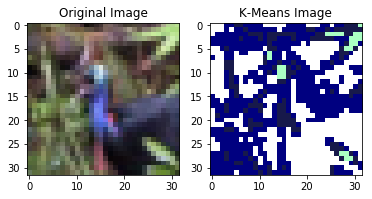

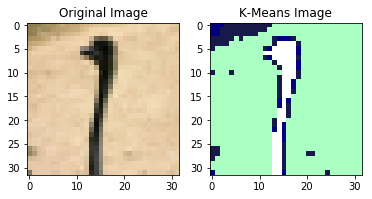

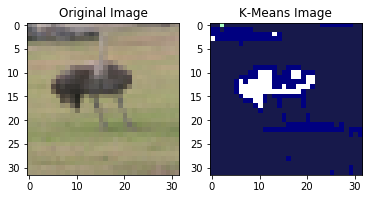

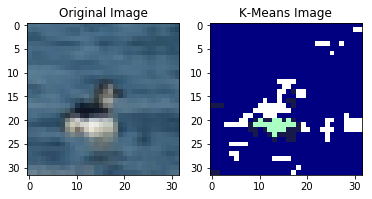

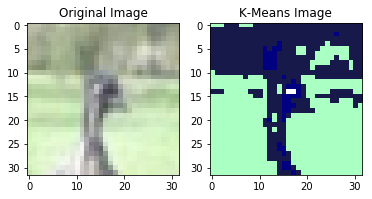

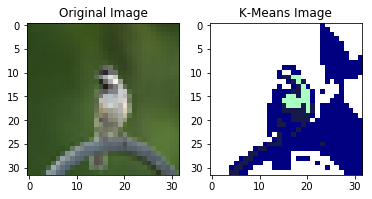

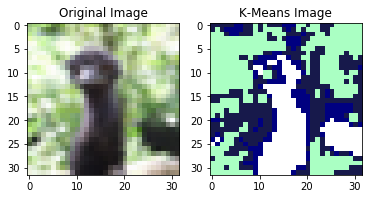

In [734]:
Navy = (0,0,128)
Red =( 230, 25, 75) 
Mint = (170, 255, 195)
White = (255, 255, 255)
clusters_centers2 = [[0.0,0.0,128],[23,25,75],[170,255,195],[255,255,255]]
clusters_centers2 = np.array(clusters_centers2)

New_pixels_2 = []
for i in labels:
    New_pixels_2.append(clusters_centers2[i])

New_pixels_2 = np.asarray(New_pixels_2)

#Wrapping the array into np.uint8() because matplot lib does not accept floats
New_pixels_2 = np.uint8(New_pixels_2)

k_means_output = New_pixels_2.reshape(6000, 32, 32, 3)

for i in range(10):
    #print("Image:",i+1)
    plt.figure(figsize=(6,6))
    plt.subplot(1, 2, 1)
    plt.imshow(x_birds_all[i])
    plt.title("Original Image")
    plt.subplot(1, 2, 2)
    plt.imshow(k_means_output[i])
    plt.title("K-Means Image")

### Converting all the images to grayscale
I've made use of the __rgb2gray__ function of the __skimage.color__ package

In [602]:
gray_img = np.empty([6000, 32, 32])
index=0
for i in x_birds_all:
    gray_img[index] = rgb2gray(i)
    index = index+1

### Splitting the images into training and test data and reshaping the numpy array

In [603]:
gray_img_train = gray_img[0:5000]
gray_img_test = gray_img[5000:]
gray_img_train = gray_img_train.reshape(5000, 32, 32,1)
gray_img_test = gray_img_test.reshape(1000, 32, 32,1)
print(gray_img_train.shape)
print(gray_img_test.shape)

(5000, 32, 32, 1)
(1000, 32, 32, 1)


### Performing one hot encoding on the labels returned by K-Means

In [738]:
Y = np.array([0,1,2,3])
target = to_categorical(labels,4)

### Reshaping the target variables

In [739]:
categorical_Target = target.reshape(6000,4096)
Y_Train = categorical_Target[0:5000]

In [740]:
Y_Test = categorical_Target[5000:]
Y_Test.shape

(1000, 4096)

### Setting up the Convolutional Neural Network
I've made use of the following architecture -<br>
1. Convolution layer with - <br>
a. 512 filters<br>
b. Kernel Size - (5,5)<br>
c. Activation Layer - __Relu__<br>
d. Padding - __same__(With Padding)<br>
e. Strides - 2<br>
2. A Max pooling layer with pool size (2,2)<br>
3. Convolution layer with - <br>
a. 256 filters<br>
b. Kernel Size - (5,5)<br>
c. Activation Layer - __Relu__<br>
d. Padding - __valid__(No Padding)<br>
e. Strides - No Strides<br>
4. A Max pooling layer with pool size (2,2)<br>
5. Flattening the output from the previous layer before sending it to the MLP(Multi Layer Perceptron)<br>
6. A dense layer with -<br>
a. 1024 nodes<br>
b. Activation Layer - __Relu__<br>
7. A softmax layer(Returns probabilities) with -<br>
a. 4096 nodes<br>

In [741]:
#Initializing a Sequential Model
model = Sequential()

#Obtaining the shape of each observation
input_shape = gray_img_train[0].shape

#Adding a convolution layer with padding and with strides
model.add(Conv2D(512,kernel_size=5,activation='relu',padding='same',strides = 2,input_shape=(n_rows,n_cols,1)))

#Adding a Max Pool layer
model.add(MaxPool2D(2))

#Adding a convolution layer with padding and with strides
model.add(Conv2D(256,kernel_size=5,activation='relu'))

#Adding a Max Pool layer
model.add(MaxPool2D(2))

#Flattening the output before passing on the values to the MLP layer
model.add(Flatten())

#First dense layer
model.add(Dense(1024,activation='relu'))

#Adding a softmax layer which returns probabilities
model.add(Dense(4096,activation='softmax'))

In [742]:
#Obtaining model summary
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_41 (Conv2D)           (None, 16, 16, 512)       13312     
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 8, 8, 512)         0         
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 4, 4, 256)         3277056   
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 2, 2, 256)         0         
_________________________________________________________________
flatten_20 (Flatten)         (None, 1024)              0         
_________________________________________________________________
dense_95 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dense_96 (Dense)             (None, 4096)              4198400   
Total para

In [744]:
#Compiling the model
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

#Adding a checkpoint to keep track of the best state of the model
filepath="cnn-{epoch:02d}-{loss:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

#Fitting the model
training = model.fit(gray_img_train,Y_Train,validation_split=0.05,validation_data = (gray_img_test,Y_Test),epochs=30,batch_size=10,callbacks=callbacks_list)

Train on 5000 samples, validate on 1000 samples
Epoch 1/30
5000/5000 [==============================] - 52s 10ms/step - loss: 8202.8590 - acc: 4.0000e-04 - val_loss: 8060.8775 - val_acc: 0.0000e+00

Epoch 00001: loss improved from inf to 8202.85896, saving model to cnn-01-8202.8590.hdf5
Epoch 2/30
5000/5000 [==============================] - 52s 10ms/step - loss: 8024.4924 - acc: 0.0000e+00 - val_loss: 8001.2959 - val_acc: 0.0000e+00

Epoch 00002: loss improved from 8202.85896 to 8024.49242, saving model to cnn-02-8024.4924.hdf5
Epoch 3/30
5000/5000 [==============================] - 51s 10ms/step - loss: 7967.3526 - acc: 4.0000e-04 - val_loss: 7961.6060 - val_acc: 0.0000e+00

Epoch 00003: loss improved from 8024.49242 to 7967.35264, saving model to cnn-03-7967.3526.hdf5
Epoch 4/30
5000/5000 [==============================] - 54s 11ms/step - loss: 7933.5156 - acc: 6.0000e-04 - val_loss: 7935.9830 - val_acc: 0.0000e+00

Epoch 00004: loss improved from 7967.35264 to 7933.51561, saving mo

### Using the above neural network to make predictions on grayscale test images

In [647]:
predictions = model.predict(gray_img_test)

### Reshaping the output

In [648]:
predictions_reshape = predictions.reshape(1000,32,32,4)

### Running through the 4 values assigned to each pixel and checking which color(K-Means cluster center) has been assigned to the same

In [649]:
new_labels = []
for i in predictions_reshape:
    for j in i:
        for k in j:
            new_labels.append(np.argmax(k))

### Assigning the cluster center associated with the label selected for each pixel in the upper loop

In [650]:
len(new_labels)
pixels = []
for i in new_labels:
    pixels.append(clusters_centers[i])

### Reshaping the output in order to plot the images

In [651]:
pixels = np.uint8(pixels)
pixels = np.array(pixels)
CNN_output = pixels.reshape(1000, 32, 32, 3)
print(CNN_output.shape)

(1000, 32, 32, 3)


### Printing the Original, Grayscale, CNN coloured image and the K-means coloured image for the fits 10 pictures in the test

Image: 1


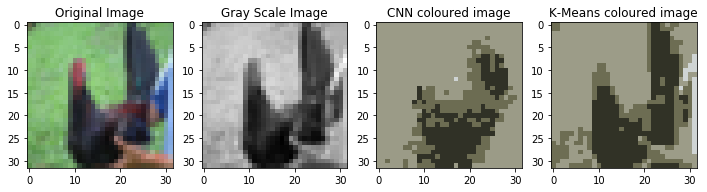

Image: 2


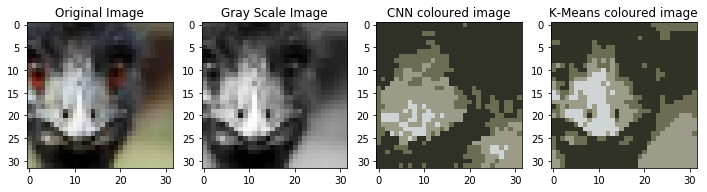

Image: 3


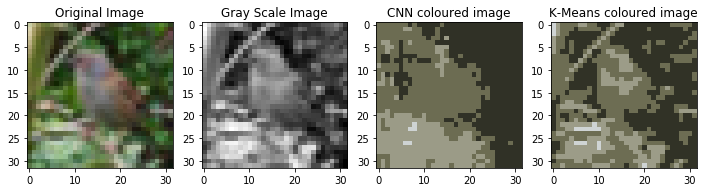

Image: 4


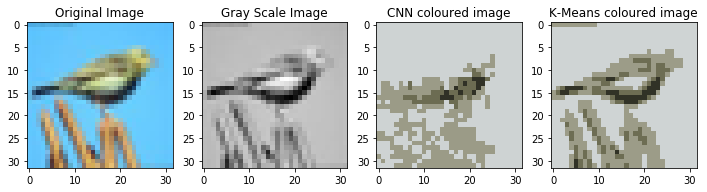

Image: 5


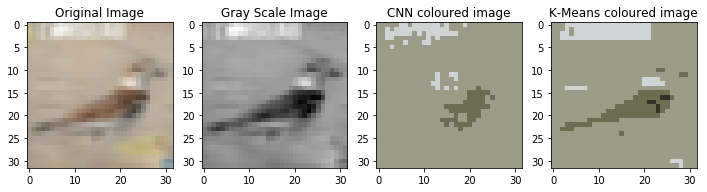

Image: 6


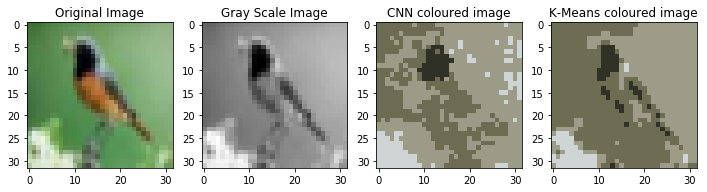

Image: 7


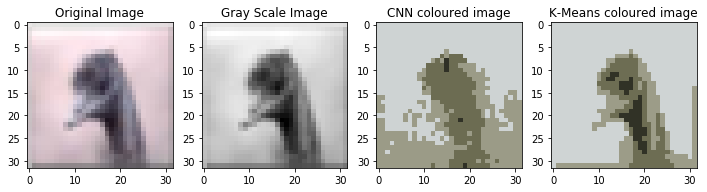

Image: 8


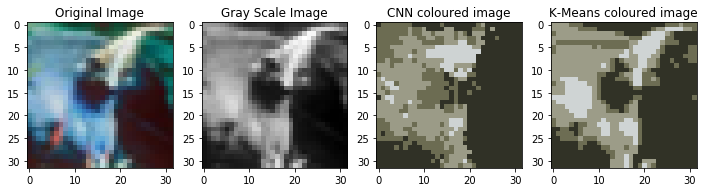

Image: 9


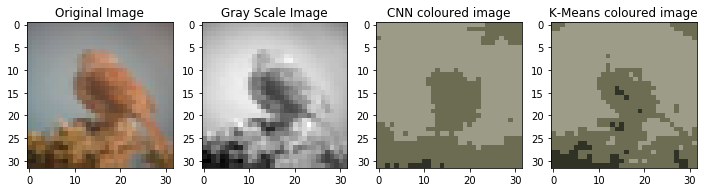

Image: 10


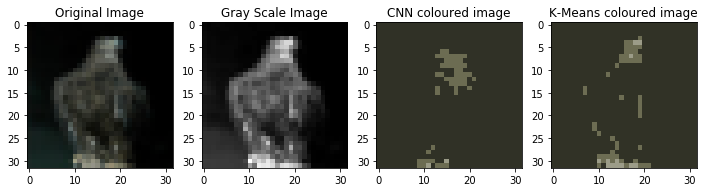

In [620]:
count=5000
for i in range(10):
    print("Image:",i+1)
    plt.figure(figsize=(12,12))
    plt.subplot(1, 4, 1)
    plt.imshow(x_birds_all[count],cmap='gray')
    plt.title("Original Image")
    plt.subplot(1, 4, 2)
    plt.imshow(gray_img[count],cmap='gray')
    plt.title("Gray Scale Image")
    plt.subplot(1, 4, 3)
    plt.imshow(CNN_output[i])
    plt.title("CNN coloured image")
    plt.subplot(1, 4, 4)
    plt.imshow(k_means_output[count])
    plt.title("K-Means coloured image")
    plt.show()
    count = count+1

### Plot of Training Dataset Loss and Validation Dataset loss

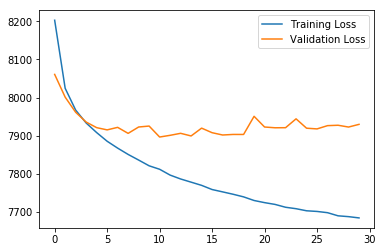

In [748]:
# Extract the history from the training object
history = training.history

# Plot the training loss 
plt.plot(history['loss'],label ="Training Loss")
# Plot the validation loss
plt.plot(history['val_loss'],label ="Validation Loss")
plt.legend(loc='best')
# Show the figure
plt.show()

From the above graph, we can see that the loss on the training data decreases with each epoch. But in the case of Validation data the loss hits a minimum value in the 10th epoch and then fluctuates slightly.

### Plot of Training Dataset Accuracy and Validation Dataset Accuracy

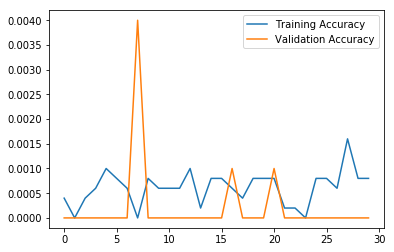

In [750]:
# Extract the history from the training object
history = training.history

# Plot the training accuracy 
plt.plot(history['acc'],label ="Training Accuracy")
# Plot the validation accuracy
plt.plot(history['val_acc'],label ="Validation Accuracy")
plt.legend(loc='best')
# Show the figure
plt.show()

The training accuracy and validation accuracy fluctuate slightly during every epoch, except for the the anomaly in epoch 7 where there is a sudden rise in validation accuracy. We can observe that the model has a pretty poor accuracy. One possible reason for the low accuracy is the small dataset.

### Plot of Training Dataset Error and Validation Dataset Error

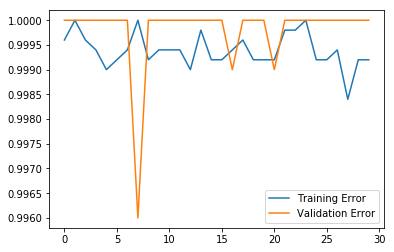

In [762]:
# Extract the history from the training object
history = training.history

training_error = [1 - i for i in history['acc']]
validation_error = [1 - i for i in history['val_acc']]

# Plot the training error 
plt.plot(training_error,label ="Training Error")
# Plot the validation error
plt.plot(validation_error,label ="Validation Error")
plt.legend(loc='best')
# Show the figure
plt.show()

The above graph is the inverse of the graph plotted previously, since __error = 1 - accuracy__. We can make the same inference from this plot, the model performs pretty poorly and has a very high training and validation error.